# Modeling 

## Load Processed Dataset 
Load cleaned and feature-engineered data output from preprocessing pipeline.

In [25]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import xgboost as xgb
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# Load training data
train_df = pd.read_csv("../data/processed/training_data.csv")

# Load final evaluation data
test_df = pd.read_csv("../data/processed/test_data.csv")

## Define Features (X) and Target (y)
Seperate the target (Log Views) and the input features for modeling 

In [3]:
# Seperating X and y for the training data
y = train_df['log_views']
X = train_df.drop(['log_views'], axis = 1 )

In [4]:
#seperating X and Y for the final evaluation data
y_eval = test_df['log_views']
X_eval = test_df.drop(['log_views'], axis = 1 )

## Train/Test Split 
Holds 20% of the data to be used to evaluate baseline model preformance for model selection.

In [5]:
# Creates train/test splits for the target variable and features.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## Baseline Models
Fit and compare several simple models to establish benchmark predictive performance.

In [6]:
# Initialising base models
linear_regressor = LinearRegression()
lasso = Lasso(alpha= 1.0)
ridge = Ridge(alpha= 1.0)
random_forest_regressor = RandomForestRegressor(n_estimators= 100, max_depth= None, random_state= 42, n_jobs= -1 )
xgb_regressor = xgb.XGBRegressor(n_estimators = 300, max_depth = 6, learning_rate = 0.1, subsample = 0.8, 
                            colsample_bytree = 0.8, random_state = 42, n_jobs = -1 )


In [7]:
# Fitting models on training data
linear_regressor.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Results & Model Selection 
Summarize baseline metrics and choose models for hyperparameter tuning.

In [8]:
# Predicts target variables based on fitted models 
linear_regression_pred = linear_regressor.predict(X_test)
lasso_pred = lasso.predict(X_test)
ridge_pred = ridge.predict(X_test)
random_forest_pred = random_forest_regressor.predict(X_test)
xgb_pred = xgb_regressor.predict(X_test)

In [9]:
# Calculates the Mean Squared Error of the models predictions and records the results
results = {}
results["linear_regression"] = mean_squared_error(y_test, linear_regression_pred)
results["lasso"] =  mean_squared_error(y_test, lasso_pred)
results["ridge"] = mean_squared_error(y_test, ridge_pred)
results["random_forest"] = mean_squared_error(y_test, lasso_pred)
results["xgb"] = mean_squared_error(y_test, xgb_pred)

In [10]:
# Displays the results in ascending order 
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')
results_df

,MSE
xgb,0.330288
ridge,0.887046
linear_regression,0.887049
lasso,1.017676
random_forest,1.017676


Since the XBG Regressor performed significantly better than the other models assessed, it will be the model selected.

## XGB Hyperparameter Tuning
Using grid search cross validation to select the best parameter value. 

In [11]:
# Creating parameter grid for grid dearch cross validation 
param_grid = {
    'n_estimators': [200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

In [12]:
# Grid search fit
grid_search = GridSearchCV(estimator= xgb.XGBRegressor(), param_grid= param_grid, cv = 5, n_jobs = -1)
grid_search.fit(X, y)

,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [17]:
# Obtaining the best parameter values evaluated from grid search
best_params = grid_search.best_params_


{'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 600,
 'subsample': 0.8}

## Evaluating Tuned Model
Evaluating the model effectiveness using the test data set aside from the preprocessing pipeline.

In [14]:
# Using tuned parameters, the model is fit on the training dataset. 
xgb_tuned= xgb.XGBRegressor(**best_params)
xgb_tuned.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1.0
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
# Predicting target variable using evaluation data
tuned_pred = xgb_tuned.predict(X_eval)

In [18]:
#Evaluating MSE
tuned_mse = mean_squared_error(y_eval, tuned_pred)
print(tuned_mse)

0.12242349376365651


In [20]:
# Fitting baseline model on whole training data and predicting on evalution data to compare to tuned model
xgb_regressor.fit(X, y)
baseline_pred = xgb_regressor.predict(X_eval)
basline_mse = mean_squared_error(y_eval, baseline_pred)
print(f"Tuned MSE: {tuned_mse}, Baseline MSE: {basline_mse}")

Tuned MSE: 0.12242349376365651, Baseline MSE: 0.3310701036452519


In [21]:
mse_dif = basline_mse - tuned_mse
print(f"Difference in MSE: {mse_dif}")

Difference in MSE: 0.2086466098815954


## Model Interpretation 
Plotting the important features of the model to allow fo interpretation

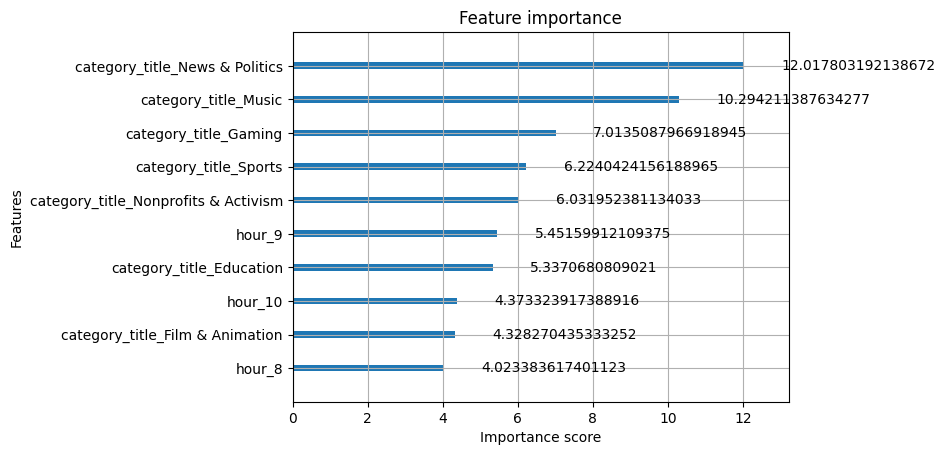

In [23]:
# Plotting top 10 important eature according to gain
xgb.plot_importance(xgb_tuned, importance_type= 'gain', max_num_features= 10)
plt.show()

Based on the plot, the primary features in the feature set dictating the view count are the video category and the time of day posted. Considering the feature that were available for modeling it makes sense that these features would have the most effect. This is because some categories would naturally get more views than others and the time the video is posted would affect how many people would be awake to see it.   

## Saving model
Saving model for reproducability and experimentation 

In [27]:

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
xgb_tuned.save_model(f"../models/xgb_model_{timestamp}.json")